<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Bi_Directional_Many_to_Many.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [43]:
import numpy as np
import tensorflow as tf
import pandas as pd

import tensorflow as tf

from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , GRU , SimpleRNN , BatchNormalization , LSTM , Bidirectional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler

# Create data

In [2]:
num_days = 700
dates = pd.date_range(start="2020-01-01", periods=num_days, freq="D")
oil_prices = 50 + 5 * np.sin(np.linspace(0, 20, num_days)) + np.random.normal(0, 1, num_days)
temperature = 30 + 10 * np.sin(np.linspace(0, 10, num_days)) + np.random.normal(0, 1, num_days)

df = pd.DataFrame({"Date": dates, "Oil_Price": oil_prices, "Temperature": temperature})

df.head()

,Date,Oil_Price,Temperature
0,2020-01-01,50.497354,30.165916
1,2020-01-02,50.542440,32.571695
2,2020-01-03,51.364855,31.927889
3,2020-01-04,50.277921,29.848715
4,2020-01-05,49.748202,30.235293


# prepartation data

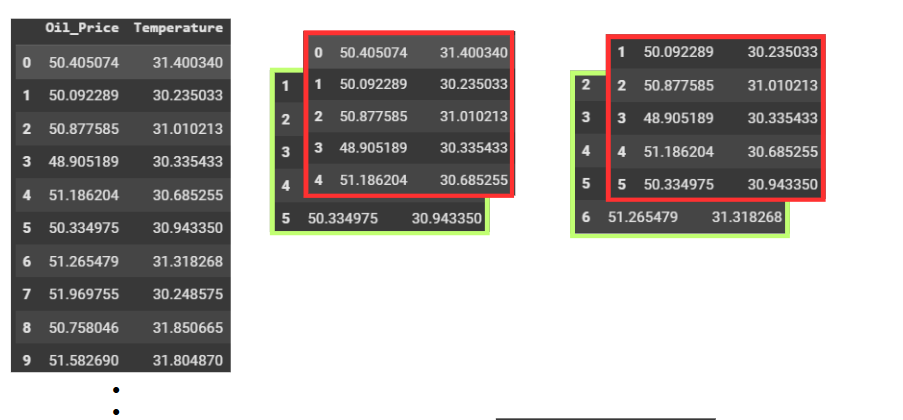

In [3]:
time_step = 5 #ใช้ข้อมูลก่อนหน้า 5 ทำนาย

In [4]:
df.head()

,Date,Oil_Price,Temperature
0,2020-01-01,50.497354,30.165916
1,2020-01-02,50.542440,32.571695
2,2020-01-03,51.364855,31.927889
3,2020-01-04,50.277921,29.848715
4,2020-01-05,49.748202,30.235293


In [30]:
X, y = [], []

for i in range(len(df) - time_step):
    X.append(df.iloc[i:i+time_step, 1:].values)
    # iloc[0:1+5] = [0 1 2 3 4]
    y.append(df.iloc[i+time_step, 1:].values)
    # iloc[0+5] = [6]


In [34]:
X[:2]

[array([[50.49735352, 30.16591589],
        [50.54244007, 32.57169475],
        [51.36485462, 31.92788926],
        [50.27792101, 29.84871451],
        [49.74820164, 30.23529329]]),
 array([[50.54244007, 32.57169475],
        [51.36485462, 31.92788926],
        [50.27792101, 29.84871451],
        [49.74820164, 30.23529329],
        [49.51405339, 29.2868384 ]])]

In [35]:
y[:2]

[array([49.51405339457741, 29.286838401071954], dtype=object),
 array([49.10755017995858, 30.590789465556107], dtype=object)]

In [36]:
# แปลงเป็น numpy array
X = np.array(X)
y = np.array(y)

# ตรวจสอบ shape
X.shape, y.shape

((695, 5, 2), (695, 2))

# splitting data

In [37]:
# แบ่งข้อมูล Train (70%) และ (Val+Test) (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False) #ห้ามสุ่มเพราะเป็น time series
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [38]:
X_train.reshape(-1, X_train.shape[-1]) #ลดให้เหลือ 2D เพราะ standardization must 2d

array([[50.49735352, 30.16591589],
       [50.54244007, 32.57169475],
       [51.36485462, 31.92788926],
       ...,
       [46.73330868, 28.85569495],
       [46.32466144, 27.84151975],
       [47.31424382, 27.15251081]])

In [40]:
#แปลงกลับ
X_train.reshape(-1, X_train.shape[-1]).reshape(X_train.shape)[:2] # == x_train แปลงกลับมา 3D เหมือนเดิม

array([[[50.49735352, 30.16591589],
        [50.54244007, 32.57169475],
        [51.36485462, 31.92788926],
        [50.27792101, 29.84871451],
        [49.74820164, 30.23529329]],

       [[50.54244007, 32.57169475],
        [51.36485462, 31.92788926],
        [50.27792101, 29.84871451],
        [49.74820164, 30.23529329],
        [49.51405339, 29.2868384 ]]])

In [41]:

# สร้างตัวแปร StandardScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit transform กับ Training data และ Transform ชุดอื่น ๆ
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

# ตรวจสอบ shape
print("Train shape:", X_train_scaled.shape, y_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape, y_val_scaled.shape)
print("Test shape:", X_test_scaled.shape, y_test_scaled.shape)


Train shape: (417, 5, 2) (417, 2)
Validation shape: (139, 5, 2) (139, 2)
Test shape: (139, 5, 2) (139, 2)


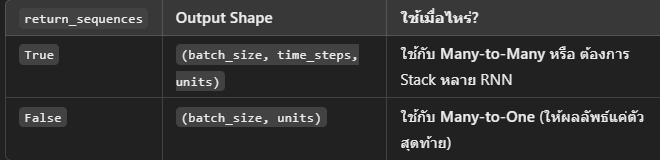

In [42]:
X_train_scaled.shape

(417, 5, 2)

# Model

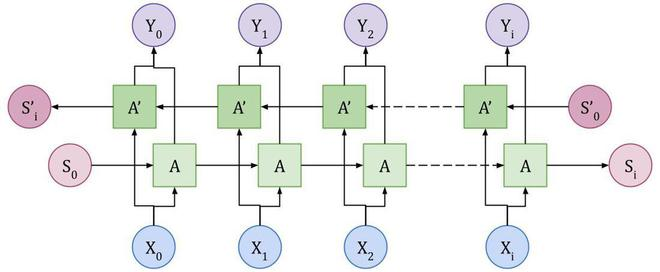

In [47]:
model = Sequential([
    Bidirectional(LSTM(128, activation='gelu', return_sequences=False),input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    BatchNormalization(),
    Dense(128, activation='gelu'),
    Dense(2)  # Output Layer
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         134,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,322 (657.51 KB)

 Trainable params: 167,810 (655.51 KB)

 Non-trainable params: 512 (2.00 KB)

In [48]:
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=50, batch_size=64, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.3079 - val_loss: 0.4911
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2578 - val_loss: 0.4717
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2270 - val_loss: 0.4548
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2151 - val_loss: 0.4401
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1885 - val_loss: 0.4276
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1634 - val_loss: 0.4163
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1369 - val_loss: 0.4057
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1214 - val_loss: 0.3948
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1057 - val_loss: 0.3837
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0942 - val_loss: 0.3723
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0739 - val_loss: 0.3616
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0655 - val_loss: 0.3511


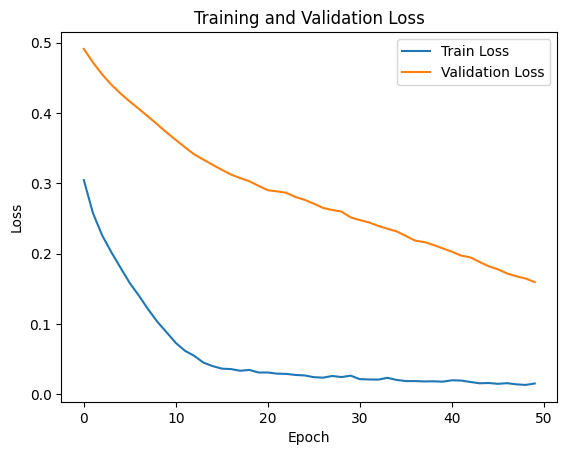

In [49]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [51]:
# ทดสอบโมเดลกับ Test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled[:5]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.2601924 , 0.35724077],
       [0.2576214 , 0.3542194 ],
       [0.25763363, 0.35379753],
       [0.25392044, 0.35494396],
       [0.25836295, 0.3524423 ]], dtype=float32)

In [52]:
# แปลงค่ากลับเป็นสเกลเดิม
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1])).reshape(y_pred_scaled.shape) #Nomalization ไม่ต้องแปลงกลับ .reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, y_test_scaled.shape[-1])).reshape(y_test_scaled.shape)
y_pred[:5] ,y_test[:5]

(array([[46.52115 , 26.783903],
        [46.48456 , 26.712902],
        [46.48473 , 26.702988],
        [46.43188 , 26.729929],
        [46.49511 , 26.671139]], dtype=float32),
 array([[47.36537387, 38.88072674],
        [48.91171043, 40.44579032],
        [46.22788267, 39.46318894],
        [49.06776927, 39.29031909],
        [48.93268058, 41.23012161]]))